In [369]:
import nltk
from nltk.corpus import stopwords
import re
import tensorflow as tf
import contractions
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score
from urlextract import URLExtract
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import VotingClassifier
from sklearn.calibration import CalibratedClassifierCV
from time import time
from sklearn.base import clone
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
import numpy as np
import matplotlib.cm as cm

# Data preparation

combining the train, test datasets into one df for easier preprocessing. Keeping track of which dataset they originaly came from through the 'split' column.

In [336]:
train = pd.read_csv('NLP_train_test/Corona_NLP_train.csv', encoding= 'latin')
test = pd.read_csv('NLP_train_test/Corona_NLP_test.csv', encoding= 'latin')
train['split'] = 'train'
test['split'] = 'test'
df = pd.concat([train, test], axis=0)
df.reset_index(drop=True, inplace=True)
del train, test

N/A values only in the Location column. We are not using it for our analysis so we drop it. ScreenName and UserName are unique identifiers and don't carry any values so they are remoed aswell.

In [337]:
df.isna().sum()

UserName            0
ScreenName          0
Location         9424
TweetAt             0
OriginalTweet       0
Sentiment           0
split               0
dtype: int64

In [338]:
df.drop(columns=['Location', 'ScreenName', 'UserName'], inplace=True)


In [339]:
df['Sentiment'].value_counts()

Sentiment
Positive              12369
Negative              10958
Neutral                8332
Extremely Positive     7223
Extremely Negative     6073
Name: count, dtype: int64

No duplicates to be removed

In [340]:
df.duplicated().sum()

0

Preprocessing of the raw tweet. Removing urls, expanding the contractions, tokenizing, removing non-alphabetical words and characters, removing stopwords. URL extranct outside

In [341]:
nltk.download('stopwords')
stopwords_list = stopwords.words('english')
stopwords_list.extend([''])
extractor = URLExtract()

def prepare_tweet(tweet):
    # Remove URLs
    urls = extractor.find_urls(tweet)
    for u in urls:
        tweet = tweet.replace(u, "")

    # Expand contractions
    tweet = contractions.fix(tweet)

    # Tokenize 
    tweet = tf.keras.preprocessing.text.text_to_word_sequence(tweet) 
    tokenized = []
    for t in tweet:
        # Ignore non-alphabetical tokens
        if not any(list(map(lambda x: x.isalpha(), t))):
            continue

        # Remove non-alphabetical characters
        t = re.sub("[^a-zA-Z]", "", t)

        # remove stopwords
        if t.lower() in stopwords_list:
            continue
        
        tokenized.append(t)

    return tokenized

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dviva\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [342]:
df['TokenizedTweet'] = df['OriginalTweet'].apply(prepare_tweet)

In [343]:
df['TokenizedTweet']

0                        [menyrbie, phil, gahan, chrisitv]
1        [advice, talk, neighbours, family, exchange, p...
2        [coronavirus, australia, woolworths, give, eld...
3        [food, stock, one, empty, please, panic, enoug...
4        [ready, go, supermarket, covid, outbreak, para...
                               ...                        
44950    [meanwhile, supermarket, israel, people, dance...
44951    [panic, buy, lot, non, perishable, items, echo...
44952    [asst, prof, economics, cconces, nbcphiladelph...
44953    [gov, need, something, instead, biar, je, raky...
44954    [forestandpaper, members, committed, safety, e...
Name: TokenizedTweet, Length: 44955, dtype: object

There are empty rows after preparation, they are removed.

In [344]:
mask = df['TokenizedTweet'].str.len() == 0
mask.sum()

16

In [345]:
df = df[~mask]

In [346]:
train_mask = df['split'] == 'train'
test_mask = ~train_mask

Mapping the Sentiment column to a numeric target to be used for modeling. Merging Extreme values with their corresponding normal value.

In [347]:
sentiment_map = {'Extremely Negative': 0, 'Negative': 0, 'Neutral': 1, 'Positive': 2, 'Extremely Positive': 2}
y = df['Sentiment'].map(sentiment_map)

# Distribution

### sentiment

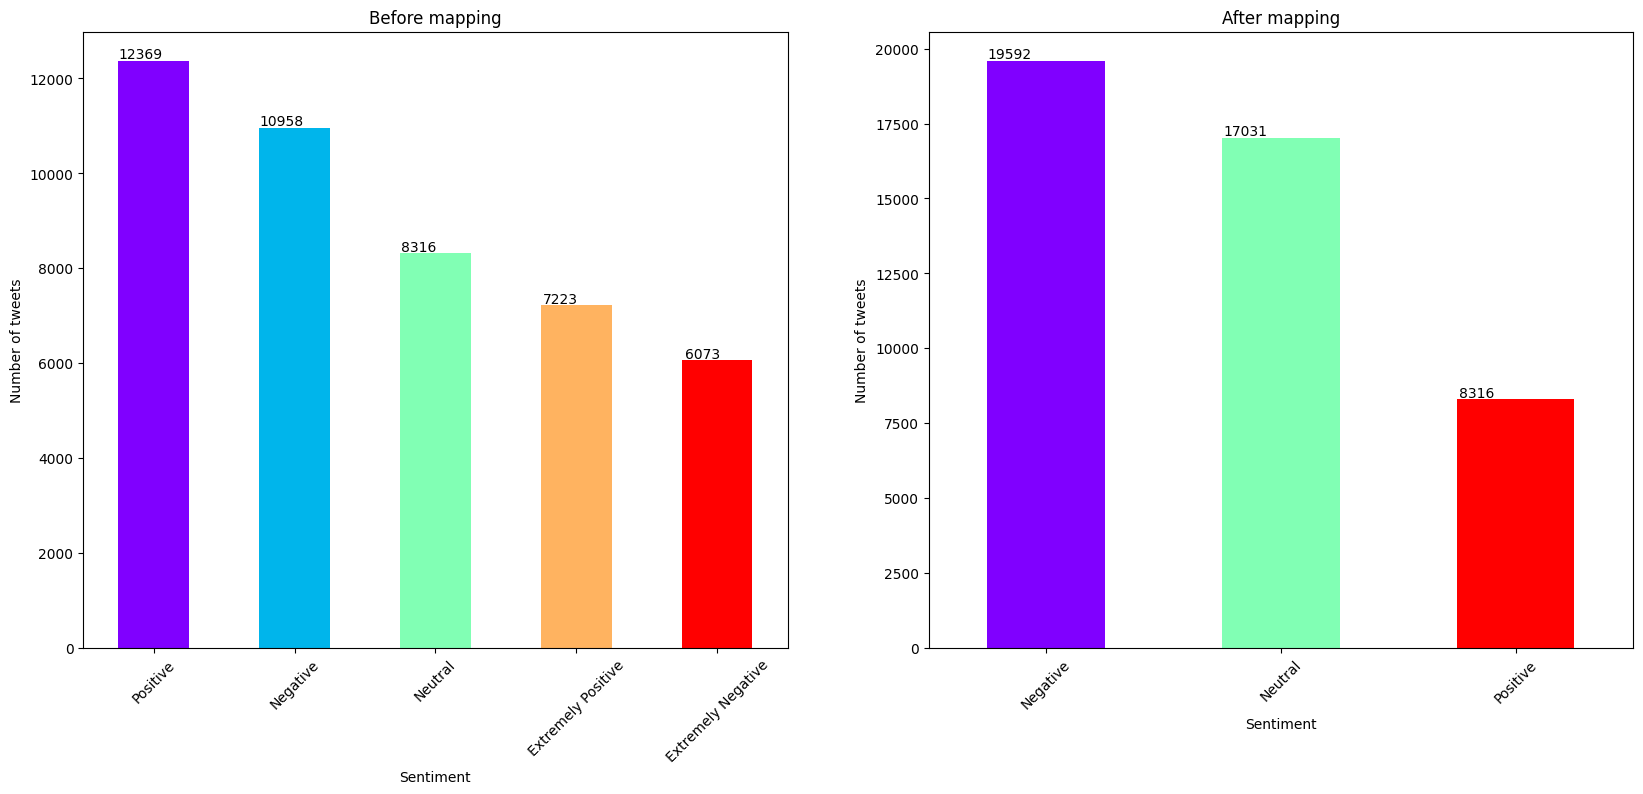

In [368]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

before_mapping_counts = df['Sentiment'].value_counts()
num_bars = len(before_mapping_counts)
colors = cm.rainbow(np.linspace(0, 1, num_bars))
before_mapping_counts.plot(kind='bar', ax=axs[0], ylabel='Number of tweets', color=colors)
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)
axs[0].set_title('Before mapping')

for p in axs[0].patches:
    axs[0].annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

after_mapping_counts = y.value_counts()
num_bars = len(after_mapping_counts)
colors = cm.rainbow(np.linspace(0, 1, num_bars))
after_mapping_counts.plot(kind='bar', ax=axs[1], ylabel='Number of tweets', color=colors)
axs[1].set_xticks([0, 1, 2])
axs[1].set_xticklabels(['Negative', 'Neutral', 'Positive'], rotation=45)
axs[1].set_title('After mapping')

for p in axs[1].patches:
    axs[1].annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()

### Tweets by date

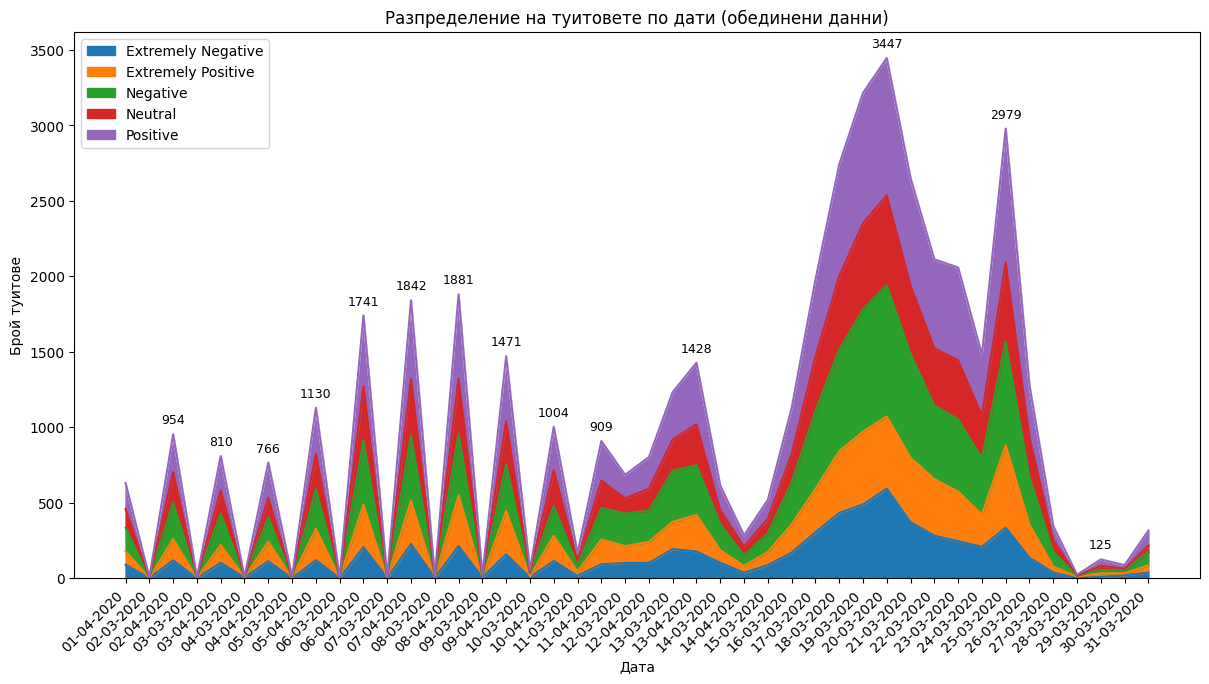

In [349]:
fig, ax1 = plt.subplots(figsize=(12, 6))
dates_distribution = df['TweetAt'].value_counts().sort_index()
ax1.plot(dates_distribution.index, dates_distribution.values, color='white')

# Търсене на локални върхове само с най-високата точка в близост
local_maxima = dates_distribution[(dates_distribution.diff().shift(-1) < 0) & (dates_distribution.diff() > 0)]

for date, count in local_maxima.items():  # Добавяне на текст само с броя туитове на върховите дати
    ax1.text(date, count + 50, f'{count}', ha='center', va='bottom', fontsize=9, color='black')

fig.tight_layout()  # За да предотвратим рязане на осите
# dates_distribution.plot(kind='area', stacked=True, ax=ax2, alpha=0.4)
df.groupby(['TweetAt', 'Sentiment']).size().unstack().plot(kind='area', stacked=True, ax=ax1)

# Форматиране оста X с по-добра четимост
ax1.set_xticks(dates_distribution.index)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.set_title('Разпределение на туитовете по дати (обединени данни)')
ax1.set_xlabel('Дата')
ax1.set_ylabel('Брой туитове')
ax1.legend()
plt.show()

Vectorization. Only tf-idf used, bernoulli has a wrapper that turns to binary so it can easily be used in an ensemble later.

In [350]:
vectorizer_bin = CountVectorizer(binary = True)
vectorizer_tfidf = TfidfVectorizer()

get_train_data = lambda: df['TokenizedTweet'][train_mask].apply(lambda r: ' '.join(r))
get_test_data = lambda: df['TokenizedTweet'][test_mask].apply(lambda r: ' '.join(r))

X_train = vectorizer_tfidf.fit_transform(get_train_data())
X_test = vectorizer_tfidf.transform(get_test_data())

# KMeans topic modeling


In [351]:
def get_top_keywords(cluster, n_terms=5):
    cluster_tweets = df.loc[df['Cluster'] == cluster, 'OriginalTweet'].fillna('').tolist()
    cluster_text = ' '.join(cluster_tweets)
    additional_stopwords = {'https', 'coronavirus', 'covid', '19', 'rt', 'amp'}

    vectorizer = CountVectorizer(stop_words='english')
    X = vectorizer.fit_transform([cluster_text])

    # Изчисляваме броя на думите
    word_counts = X.sum(axis=0).A1
    keywords = [(word, word_counts[idx]) for word, idx in vectorizer.vocabulary_.items()]
    # Филтрираме ключови думи, които са в списъка със стоп думи
    filtered_keywords = [word for word, _ in sorted(keywords, key=lambda x: x[1], reverse=True)
                         if word not in additional_stopwords]

    # Ограничаваме до първите n_terms ключови думи
    return "\n".join(filtered_keywords[:n_terms])

def generate_topic_labels(kmeans_keywords):
    used_labels = set()  # Сет за следене на използваните имена на темите
    topic_labels = []

    for _, keywords in kmeans_keywords.items():
        # Вземаме първите 2 ключови думи като предложение за име на темата
        potential_label = keywords.split("\n")[:2]
        label = " ".join(potential_label).strip()

        # Проверка за уникалност на името на темата
        base_label = label
        suffix = 1
        while label in used_labels:
            # Ако има повторение, добавяме числов суфикс
            label = f"{base_label} {suffix}"
            suffix += 1

        used_labels.add(label)
        topic_labels.append(label)

    return topic_labels

In [370]:
max_ss = -1
optimal_k = None
best_labels = None
for k in range(2, 11):
    print(f" - Тестване на {k} клъстера...")
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_train)
    sil_score = silhouette_score(X_train, labels)
    if sil_score <= max_ss: continue
    max_ss = sil_score
    optimal_k = k
    best_labels = labels
df.loc[train_mask, 'Cluster'] = best_labels
optimal_k

 - Тестване на 2 клъстера...
 - Тестване на 3 клъстера...
 - Тестване на 4 клъстера...
 - Тестване на 5 клъстера...
 - Тестване на 6 клъстера...
 - Тестване на 7 клъстера...
 - Тестване на 8 клъстера...
 - Тестване на 9 клъстера...
 - Тестване на 10 клъстера...


10

C:\Users\dviva\AppData\Local\Temp\ipykernel_28512\259123396.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=topic_labels, y='Брой туитове', data=kmeans_counts, palette="hsv")


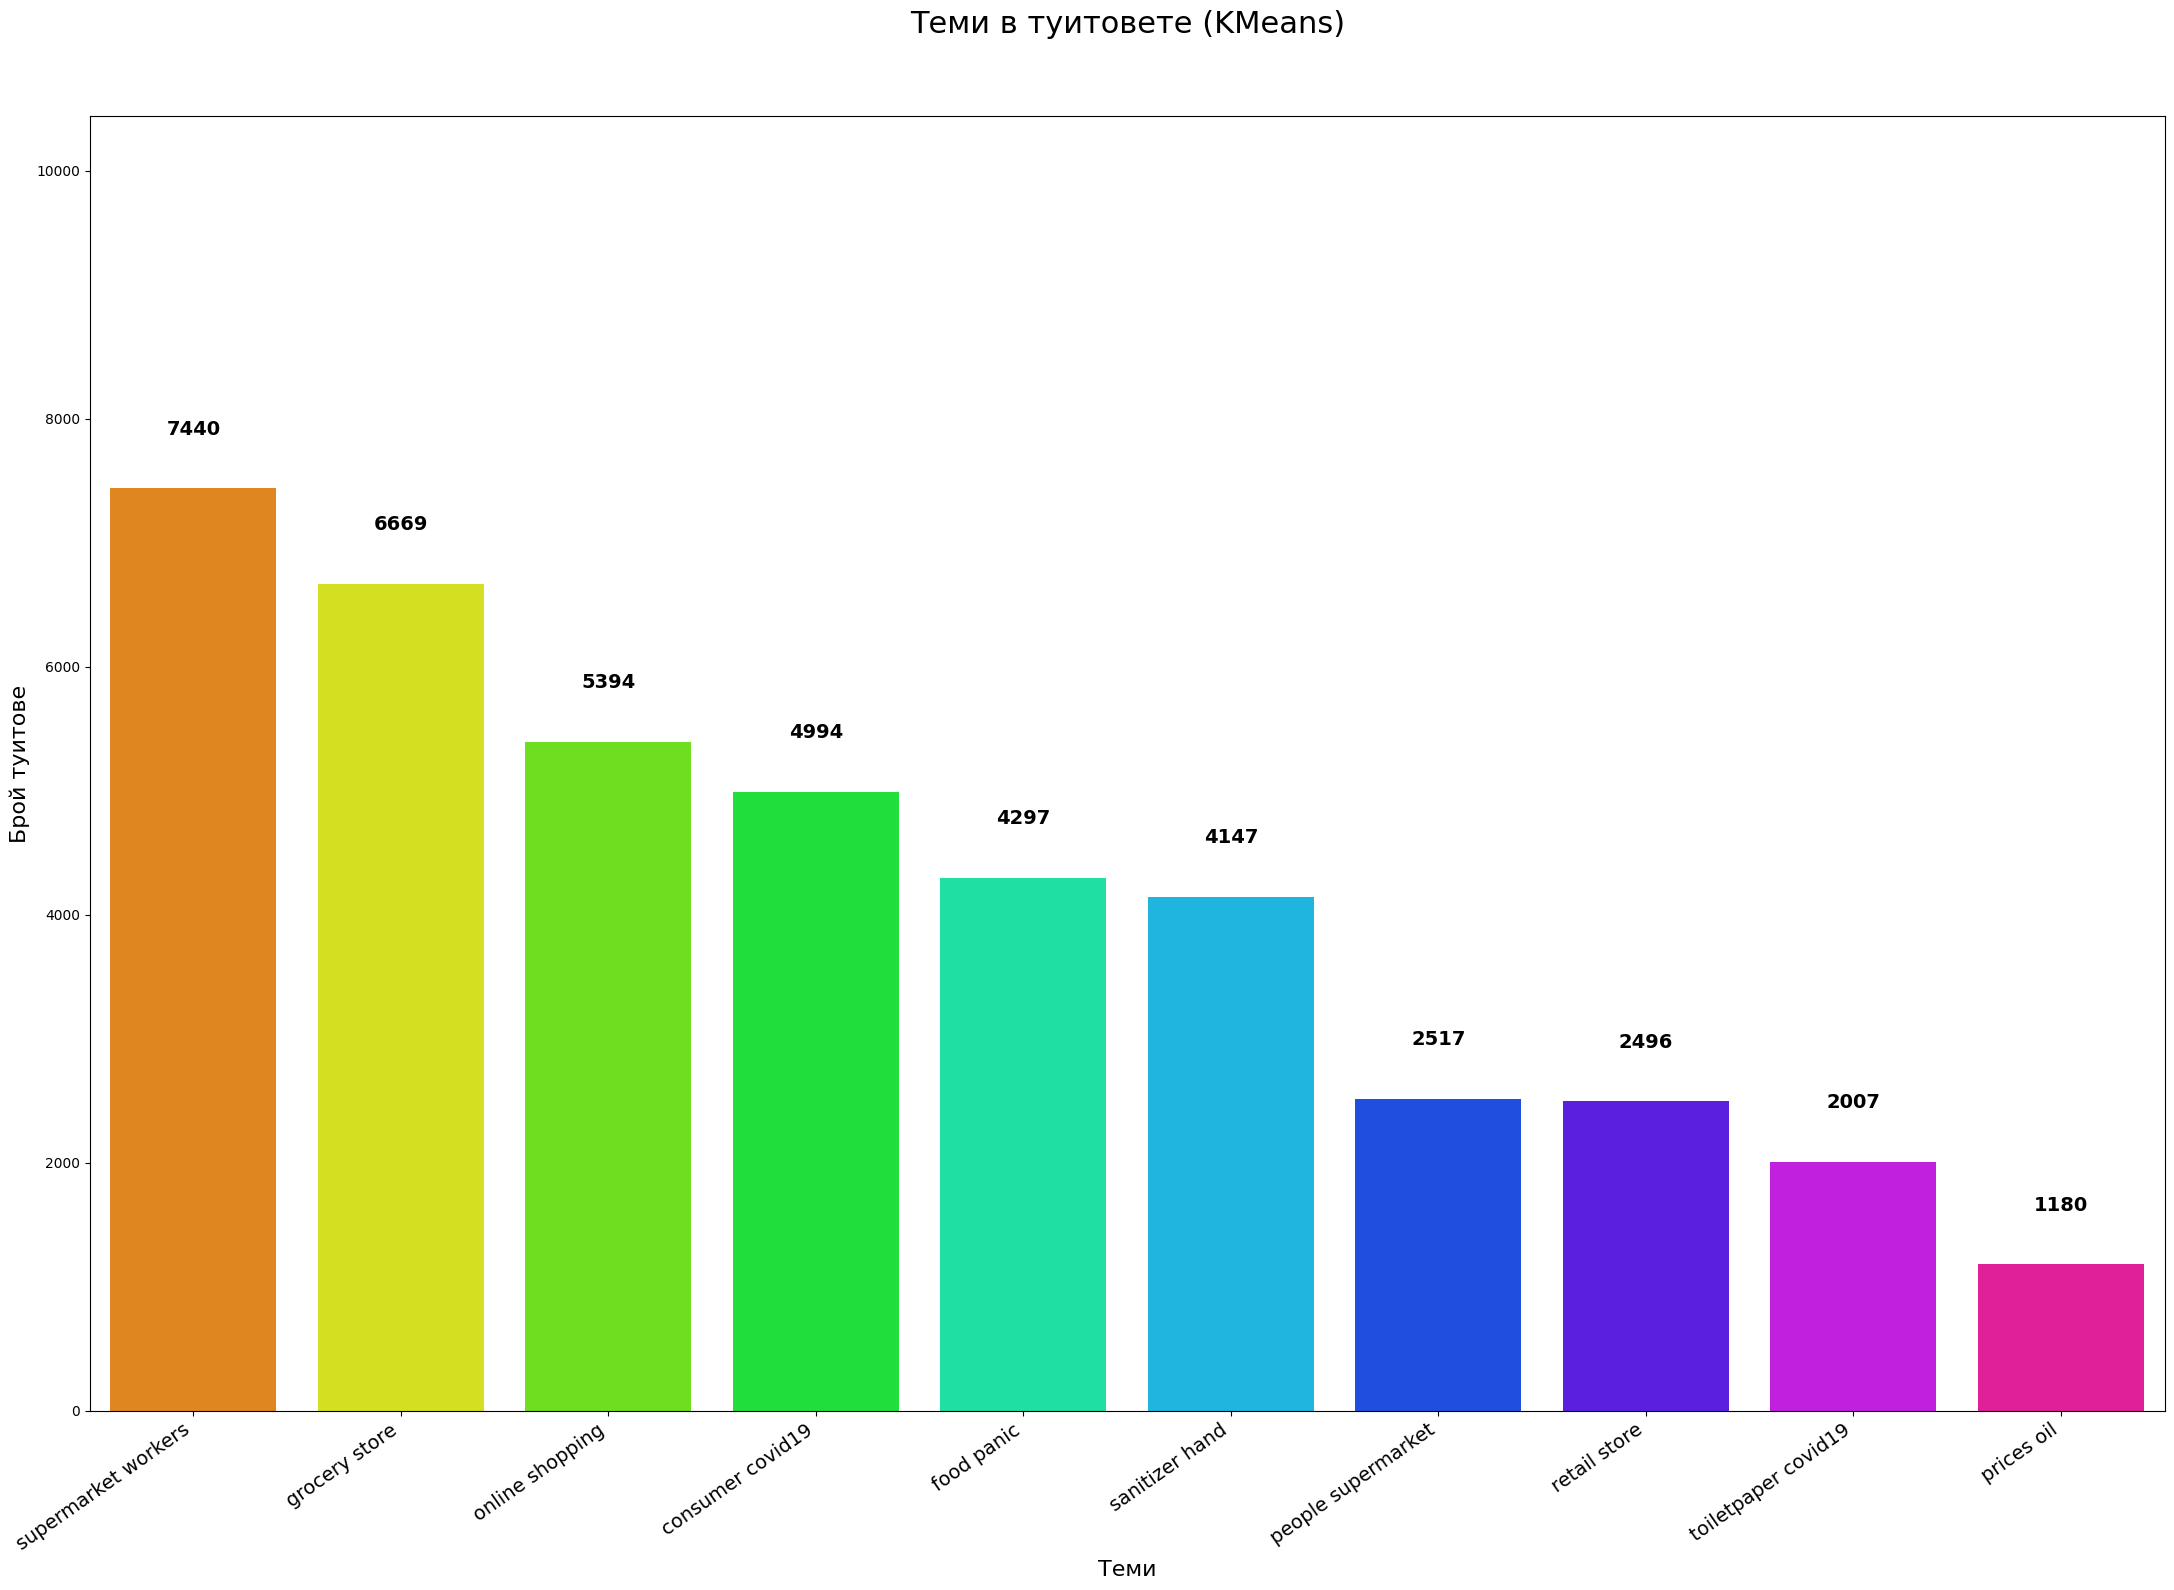

In [353]:
kmeans_keywords = {cluster: get_top_keywords(cluster) for cluster in range(optimal_k)}
topic_labels = generate_topic_labels(kmeans_keywords)

kmeans_counts = df['Cluster'].value_counts().reset_index()
kmeans_counts.columns = ['Тема', 'Брой туитове']

plt.figure(figsize=(22, 16))
bars = sns.barplot(x=topic_labels, y='Брой туитове', data=kmeans_counts, palette="hsv")

# Добавяме броя на туитовете върху стълбчетата с оптимизирано разстояние
for bar, (topic, count) in zip(bars.patches, kmeans_counts.values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 400, f'{int(count)}',
             ha='center', va='bottom', fontsize=14, fontweight='bold')

# Разширяваме полето за заглавието и увеличаваме шрифта
plt.title('Теми в туитовете (KMeans)', fontsize=22, pad=60)  # Увеличен padding за заглавието
plt.xlabel('Теми', fontsize=16)
plt.ylabel('Брой туитове', fontsize=16)

# Значително разширяваме пространството под етикетите на X оста
plt.xticks(rotation=35, ha='right', fontsize=14)
plt.subplots_adjust(bottom=0.7, top=0.77)  # Още повече разстояние долу и горе

# Увеличаваме лимита на оста Y за повече пространство над числата
max_count = kmeans_counts['Брой туитове'].max()
plt.ylim(0, max_count + 3000)  # Оставяме повече място над стълбчетата

plt.tight_layout()  # Оптимизация за избягване на припокриване
plt.show()


<Figure size 1800x1000 with 0 Axes>

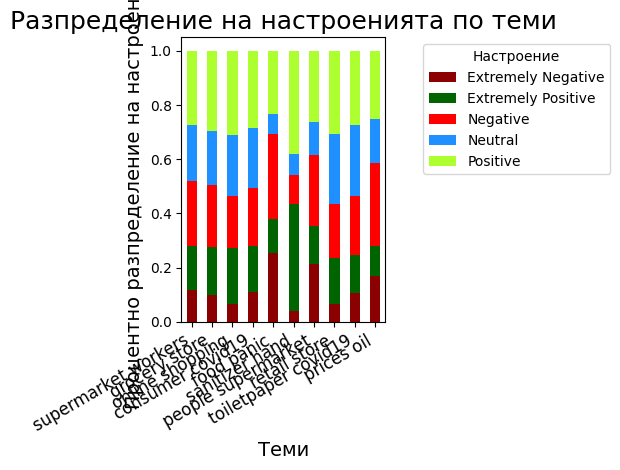

In [354]:
custom_colors = {
    'Extremely Negative': '#8B0000',  # Тъмно червено
    'Negative': '#FF0000',            # Червено
    'Neutral': '#1E90FF',             # Синьо
    'Positive': '#ADFF2F',            # Светло зелено
    'Extremely Positive': '#006400'   # Тъмно зелено
}

# Групиране на туитовете по клъстери и изчисляване на разпределението на настроенията
sentiment_distribution = df.groupby('Cluster')['Sentiment'].value_counts(normalize=True).unstack().fillna(0)

# Визуализация на разпределението на настроенията
plt.figure(figsize=(18, 10))
sentiment_distribution.plot(kind='bar', stacked=True,
                            color=[custom_colors[col] for col in sentiment_distribution.columns if col in custom_colors])

# Настройка на заглавието и осите
plt.title('Разпределение на настроенията по теми', fontsize=18)
plt.xlabel('Теми', fontsize=14)
plt.ylabel('Процентно разпределение на настроенията', fontsize=14)
plt.legend(title='Настроение', bbox_to_anchor=(1.15, 1), loc='upper left')

# Използваме реалните имена на темите от първата графика (topic_labels)
plt.xticks(ticks=range(len(topic_labels)), labels=topic_labels, rotation=30, ha='right', fontsize=12)

plt.tight_layout()  # За да избегнем припокриване на елементи
plt.show()

# Modeling

a function to time the fit and prediction of a model as average of n iterations.

In [355]:
def time_model(model, X_train, y_train, X_test, n_iter=10):
    st_fit = time()
    for _ in range(n_iter - 1):
        clone(model).fit(X_train, y_train)
    model = clone(model)
    model.fit(X_train, y_train)
    et_fit = time()

    st_pred = time()
    for _ in range(n_iter):
        pred = model.predict(X_test)
    et_pred = time()
    return pred, (et_fit - st_fit) / n_iter, (et_pred - st_pred) / n_iter

### BernoulliNB

BernoulliNB expects a binary vector, while the other models expect a tf-ird vector. The ensemble will receive tf-idf, so the BNB should have a wrapper to transform tf-idf into binary before any operations.

In [356]:
class BernoulliNBWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.model = BernoulliNB()
        self.transform = lambda X: (X > 0).astype(int)
        
    def fit(self, X, y):
        self.model.fit(
            self.transform(X), 
            y
        )
        return self
    
    def predict(self, X):
        return self.model.predict(self.transform(X)) 
    
    def predict_proba(self, X):
        return self.model.predict_proba(self.transform(X)) 

model_bnb = BernoulliNBWrapper()
pred_bnb, time_bnb_fit, time_bnb_pred = time_model(model_bnb, X_train, y[train_mask], X_test)

### LogisticRegression

In [357]:
model_lr = LogisticRegression(max_iter=1000)
pred_lr, time_lr_fit, time_lr_pred = time_model(model_lr, X_train, y[train_mask], X_test)

### Linear SVC

In [358]:
linear_lsvc = LinearSVC(dual=False, penalty='l2', loss='squared_hinge')
grid_search = GridSearchCV(linear_lsvc, param_grid={'C': [0.01, 0.1, 1, 10]}, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y[train_mask])
model_lsvc = grid_search.best_estimator_
pred_lsvc, time_lsvc_fit, time_lsvc_pred = time_model(model_lsvc, X_train, y[train_mask], X_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


### Ensemble (hard voting)

In [359]:
hard_ensemble = VotingClassifier(
    estimators=[
        ('bnb', model_bnb),
        ('lr', model_lr),
        ('lsvc', model_lsvc)
    ],
    voting='hard'
)
pred_hard_ens, time_hard_ens_fit, time_hard_ens_pred = time_model(hard_ensemble, X_train, y[train_mask], X_test)

### Ensemble (soft voting)

In [360]:
soft_ensemble = VotingClassifier(
    estimators=[
        ('bnb', model_bnb),
        ('lr', model_lr),
        ('lsvc', CalibratedClassifierCV(estimator=model_lsvc))
    ],
    voting='soft'
)
pred_soft_ens, time_soft_ens_fit, time_soft_ens_pred = time_model(soft_ensemble, X_train, y[train_mask], X_test)

# Results

In [361]:
def confusion_matrix_classification_report(y, preds, labels):
    cm = confusion_matrix(y, preds)
    matrix = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    matrix.plot(cmap='Blues')
    f1 = f1_score(y, preds, average='weighted')
    plt.title(f'F1 score {f1:.2f}')
    plt.show()
    return f1, classification_report(y, preds)

### BernoulliNB
The model does not do well with the neutral class. The precision is ok (similar to the other classes), which means that when а tweet is predicted as neutral, it is likely that it really is neutral. The problem is the recall. Of all the True neutral classes, hardly any are predicted as neutral.

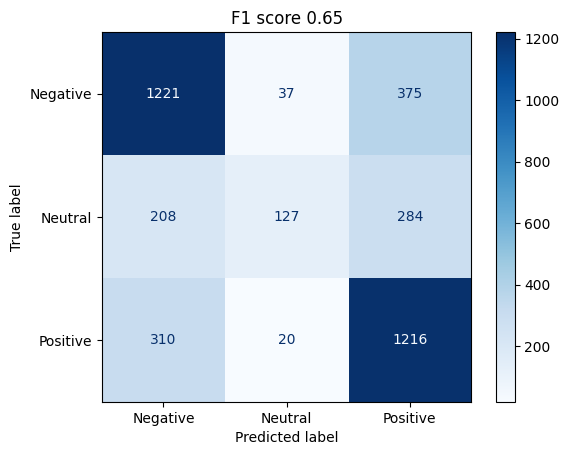

              precision    recall  f1-score   support

           0       0.70      0.75      0.72      1633
           1       0.69      0.21      0.32       619
           2       0.65      0.79      0.71      1546

    accuracy                           0.68      3798
   macro avg       0.68      0.58      0.58      3798
weighted avg       0.68      0.68      0.65      3798



In [362]:
f1bnb, rep = confusion_matrix_classification_report(y[test_mask], pred_bnb, ['Negative', 'Neutral', 'Positive'])
print(rep)

### LogisticRegression

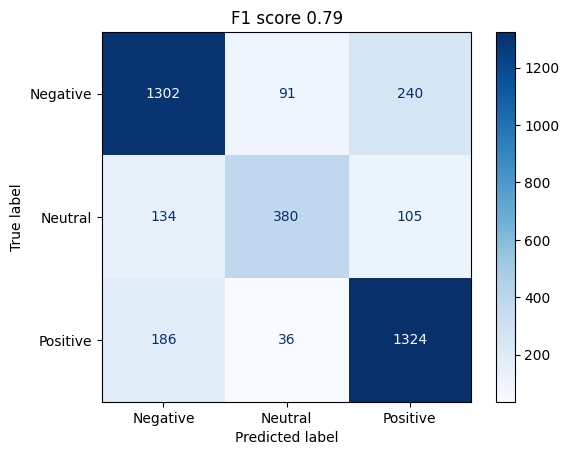

              precision    recall  f1-score   support

           0       0.80      0.80      0.80      1633
           1       0.75      0.61      0.67       619
           2       0.79      0.86      0.82      1546

    accuracy                           0.79      3798
   macro avg       0.78      0.76      0.77      3798
weighted avg       0.79      0.79      0.79      3798



In [363]:
f1lr, rep = confusion_matrix_classification_report(y[test_mask], pred_lr, ['Negative', 'Neutral', 'Positive'])
print(rep)

### Linear SVC

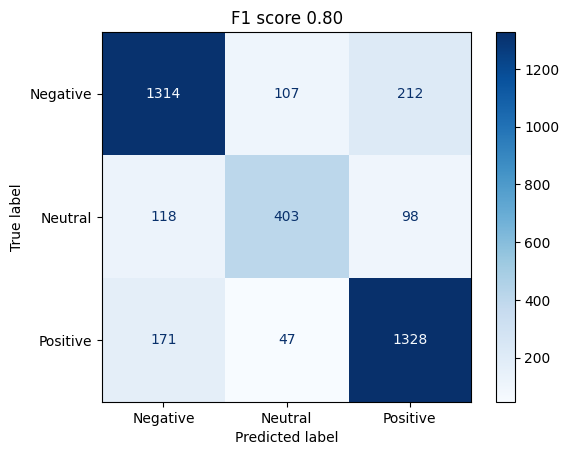

              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1633
           1       0.72      0.65      0.69       619
           2       0.81      0.86      0.83      1546

    accuracy                           0.80      3798
   macro avg       0.78      0.77      0.78      3798
weighted avg       0.80      0.80      0.80      3798



In [364]:
f1lsvc, rep = confusion_matrix_classification_report(y[test_mask], pred_lsvc, ['Negative', 'Neutral', 'Positive'])
print(rep)

### Ensemble (hard voting)

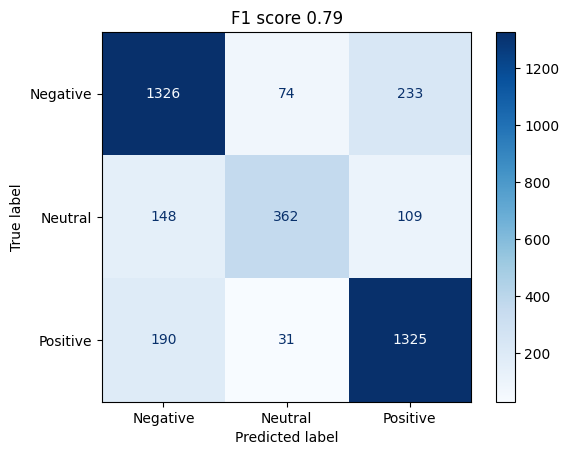

              precision    recall  f1-score   support

           0       0.80      0.81      0.80      1633
           1       0.78      0.58      0.67       619
           2       0.79      0.86      0.82      1546

    accuracy                           0.79      3798
   macro avg       0.79      0.75      0.77      3798
weighted avg       0.79      0.79      0.79      3798



In [365]:
f1_hard_ens, rep = confusion_matrix_classification_report(y[test_mask], pred_hard_ens, ['Negative', 'Neutral', 'Positive'])
print(rep)

### Ensemble (soft voting)

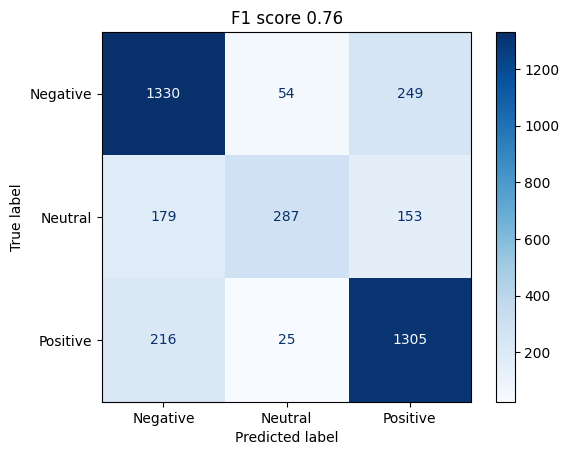

              precision    recall  f1-score   support

           0       0.77      0.81      0.79      1633
           1       0.78      0.46      0.58       619
           2       0.76      0.84      0.80      1546

    accuracy                           0.77      3798
   macro avg       0.77      0.71      0.73      3798
weighted avg       0.77      0.77      0.76      3798



In [366]:
f1_soft_ens, rep = confusion_matrix_classification_report(y[test_mask], pred_soft_ens, ['Negative', 'Neutral', 'Positive'])
print(rep)

### Results summary

BernoulliNB has a significant advatnage in fit time. Other than that, the LinearSVC is by far the best model with the fastest prediction time and the best f1 score, so once the fitted, this is the best choice. 

In [367]:
fit_times = [time_bnb_fit, time_lr_fit, time_lsvc_fit, time_hard_ens_fit, time_soft_ens_fit]
pred_times = [time_bnb_pred, time_lr_pred, time_lsvc_pred, time_hard_ens_pred, time_soft_ens_pred]
res = pd.DataFrame({
    'Fit time (s)': fit_times,
    'Prediction time (s)': pred_times,
    'f1 score': [f1bnb, f1lr, f1lsvc, f1_hard_ens, f1_soft_ens],
    '% increase relative to BNB fit time': [(x - time_bnb_fit)/time_bnb_fit*100 for x in fit_times],
    '% increase relative to BNB pred time': [(x - time_bnb_pred)/time_bnb_fit*100 for x in pred_times]
}, index=['BernoulliNB', 'LinearRegression', 'LinearSVC', 'Hard voting', 'Soft voting'])
res.sort_values(by='f1 score', ascending=False)

,Fit time (s),Prediction time (s),f1 score,% increase relative to BNB fit time,% increase relative to BNB pred time
LinearSVC,3.800186,0.000452,0.800436,19300.847038,-25.847616
Hard voting,12.850649,0.022740,0.790232,65505.603668,87.939905
LinearRegression,8.783168,0.001073,0.789243,44740.148910,-22.675880
Soft voting,23.790410,0.020374,0.762162,121355.669213,75.859118
BernoulliNB,0.019588,0.005515,0.652310,0.000000,0.000000
